In [1]:
#@title load modules and select input PLAID file
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import glob
import os
import math
import re
import datetime

from google.colab import files
uploaded = files.upload()

Saving BF-MOA-LIVE.csv to BF-MOA-LIVE (2).csv


In [70]:
#@title User input 

# https://dispendix.com/idot-dispensing-plates/

file = next(iter(uploaded))
df = pd.read_csv(file, usecols=["plateID","well","cmpdname", "CONCuM"])

user_name             = 'Jonne' #@param ["Jonne", "Christa", "Amelie","Malin","Martin","Polina","Ovidiu","Axel","David"]
protocol_name         = "myexp" #@param {type:"string"} # Name of the protocol

sourceplate_type      = "S.100 Plate" #@param ["S.100 Plate","S.60 Plate","S.200 Plate"] 
target_plate_type     = 'MWP 384' #@param ["MWP 96","MWP 384"]

working_volume_ul     = 40.0 #@param {type:"number"}
V2_ul                 = working_volume_ul

x = datetime.datetime.now()

software      = "1.7.2021.1019" # I-DOT Assay Studio software version
user_name     = user_name # User name/ID
date          = (x.strftime("%x")) 
time          = (x.strftime("%X")) 


max_volume       = 8.0E-5 # Source plate max volume (80000nL = 80uL= 8.0E-5 L)
waste            = "Waste Tube" # Position of the waste well on the target carrier

dispense_to_waste          = True # Enable/disable priming before dispensing (=True/False) 
dispense_to_waste_cycles   = 3    # Number of priming cycles for each source well (=1/2/3)
dispense_to_waste_volume   = 1e-7 # Dispensing volume for each priming cycle (=5e-8/.../1e-6) 
use_deionisation           = True
optimization_level         = "ReorderAndParallel" # Used protocol optimization process to reduce total dispensing time. Possible values are NoOptimization / Reorder / ReorderAndParalell
waste_error_handling_level = "Ask" # Checkpoint for the dispensing run if no droplets are detected during priming. Possible values are Ask / Abort / Continue 
save_liquids               = "Ask" # Checkpoint for Liquid Library handling. Possible options are Ask / Never


In [71]:
#@title Reformat combinations

# combinations should be noted as following:
#        compounds  1-3-7 combinations are assigned by dashes
#        doses:     a-j-b an equal number of doses is assigned as the number of compounds

combinations          = False #@param {type:"boolean"}

if combinations == True:
  for plate, well, compound, conc in zip(df["plateID"], df["well"],df["cmpdname"], df["CONCuM"]): 
      df_master = []
      # find only conditions that have combinations
      if '-' in compound:
          
          cmpds     = compound.split("-")
          conc      = concentrations.split("-")
          
          df = pd.DataFrame({'cmpdname':cmpds})
          
          df["CONCuM"]    = conc
          df["well"]      = well
          df["plateID"]   = plate
          
          master_df.append(df)
          
      else:
          
          df['cmpdname'] = compound 
          df["CONCuM"]   = conc
          df["well"]     = well
          df["plateID"]  = plate
          
          df_master.append(df)
else:
  None

In [72]:
#@title Do you want to change doses in PLAID?
change_conc_PLAID         = False #@param {type:"boolean"}

# e.g. assign dose from letter
if change_conc_PLAID == True:
  newconc = {'a': 0.001, 'b': 0.01, 'c': 0.1, 'd': 1} # here you assign the new names of choice! 
  df = df.replace({"CONCuM": newconc})
  df = df.reset_index()
else:
  None

In [73]:
#@title Select units used in experiment (plaid)

unit                  = "uM" #@param ["pM","nM","uM","mM","dilution"]

# default is uM - here we will recalculate if you have put in another format
file = next(iter(uploaded))
df = pd.read_csv(file, usecols=["plateID","well","cmpdname","CONCuM"])
df['CONCuM'] = pd.to_numeric(df['CONCuM'], errors='coerce')

if unit == "uM":
  None
elif unit == "pM":
  df['CONCuM'] =  df["CONCuM"]/ 1000000
elif unit == "nM":
  df['CONCuM'] = df["CONCuM"]/ 1000
elif unit == "mM":
  df['CONCuM'] = df["CONCuM"] * 1000
elif unit == "dilution":
  df['CONCuM'] = df["CONCuM"] * 1000

  
# 1 Micromolar [µM] = 0.001 Millimolar [mM]
# 1 Micromolar [µM] = 1000 Nanomolar [nM]
# 1 Micromolar [µM] = 1.0×106 Picomolar [pM] (1000000)


In [74]:
#@title Assign treatment groups

def treatmentstodict(conditions):
    DMSO, ctrls, blank, trt = ([] for i in range(4))
    catdict = {}
    
    for i in conditions:
        if bool(re.search('.*dmso.*', i,re.IGNORECASE)):
            findDMSO = re.findall('.*dmso.*', i, re.IGNORECASE) 
            DMSO.append(i)
            if findDMSO[0] not in catdict:
                catdict[i] = "DMSO" 
            

        elif bool(re.search('.*blank.*', i,re.IGNORECASE)):
            findblank = re.findall('.*blank.*', i, re.IGNORECASE) 
            blank.append(i)
            if findblank[0] not in catdict:
                catdict[i] = "blank" 
            

        elif bool(re.search(r'\[.*?\]', i)):
            findctrl = re.findall(r'\[[a-zA-Z0-9_]{4}?\]', i) 
            ctrls.append(i)
            if findctrl[0] not in catdict:
                catdict[i] = "ctrl" 
            
        else:
            if i not in catdict:
                trt.append(i)
                catdict[i] = "trt" 
    return catdict


conditions = np.unique(df[['cmpdname']].values).tolist()
catdict = treatmentstodict(conditions)
df["treatment_type"]       = df["cmpdname"].map(catdict)
df["treatment_type"].value_counts()

ctrl    196
DMSO    188
Name: treatment_type, dtype: int64

In [75]:
#@title Assign the highest available stock to each condition
maxmM_treat           = 100 #@param {type:"number"}
maxmM_ctrl            = 10 #@param {type:"number"}

# advanced settings: different stocks for each compound
advanced_manual_list_stocks           = False #@param {type:"boolean"}

In [76]:
#@title optional (advanced)
#advanced option: read from csv (if selected yes in previous question)

if advanced_manual_list_stocks == True:
  getcmpddose = df[["cmpdname","CONCuM"]].drop_duplicates()
  getcmpddose['highest_stock_mM'] = ''
  getcmpddose.to_csv("highest_stock_manual.csv", index=False,encoding = 'utf-8-sig') 
  files.download("highest_stock_manual.csv")
else:
  None
  

In [77]:
#@title optional (advanced)
# here you upload a file with your requested stocks
if advanced_manual_list_stocks == True:
  uploaded_file = files.upload()
else:
  None

In [78]:
#@title highest stock
# and then we link it to your file
if advanced_manual_list_stocks == True: 
  file = next(iter(uploaded_file))
  manualstocks = pd.read_csv(file, usecols=["cmpdname","CONCuM","highest_stock_mM"])
  manualstocks['cmpd_dose'] = manualstocks['cmpdname'] + "[" +  manualstocks['CONCuM'].astype(str) + "]"
  manualstocks = manualstocks[["cmpd_dose","highest_stock_mM"]]
  manualstocksdict = dict(zip(manualstocks.cmpd_dose, manualstocks.highest_stock_mM))

  df['cmpd_dose']              = df['cmpdname'] + "[" +  df['CONCuM'].astype(str) + "]"
  df["highest_stock_mM"]       = df["cmpd_dose"].map(manualstocksdict)
  df = df.drop('cmpd_dose', axis=1) 
else:
  None

# if answered "No" manual list it will assign stocks based on answer above

def stockhighestmM(treatment_type,maxmM_treat,maxmM_ctrl):
    if treatment_type == "trt":
        return maxmM_treat
    if treatment_type == "ctrl":
        return maxmM_ctrl
    if treatment_type == "DMSO":
        return 0
    if treatment_type == "blank":
        return 0

if advanced_manual_list_stocks == False: 
  df["highest_stock_mM"]     = df.apply(lambda x: stockhighestmM(x['treatment_type'],maxmM_treat,maxmM_ctrl), axis=1)


In [79]:
#@title Then we find an optimal stock concentration for each well
dmso_percmax           = 0.2 #@param {type:"number"}

def log10range(max_mM):
    availstocks_mM = []  
    
    maxlog10 = int(math.log(max_mM,10))
    
    for i in range(-12, maxlog10 + 1):
        availstocks_mM.append(pow(10, i))
        
    return availstocks_mM
  
def stockfinder(concUM,highest_stock_mM,V2_ul,dmso_percmax): 
    
    if highest_stock_mM != 0:
        availstocks_mM = log10range(highest_stock_mM)

        if sourceplate_type == "S.200":
          MinV1_nl = 30 
        else:
          MinV1_nl = 8

        MaxV1_nl = (dmso_percmax / 100) * (V2_ul*1000)                                                                  

        C1_low  = (V2_ul * concUM) / MaxV1_nl                                                  
        C1_high = (V2_ul * concUM) / MinV1_nl                                                 

        psblstocks = [x for x in availstocks_mM if x >= C1_low and x <= C1_high]    
        
        if psblstocks:
            highestStock = max(psblstocks)   # select highest stock for your condition                                            
            return highestStock    
        else:
            raise Exception("not possible to find a suitable stock for requested settings")
    else:
        return 0

df["stock_conc_mM"]        = df.apply(lambda x: stockfinder(x['CONCuM'],x["highest_stock_mM"],V2_ul,dmso_percmax), axis=1)

In [80]:
#@title Calculate volumes for spotting

# calculate the volumes for spotting

def uLfromstock(concUM,stock_conc_mM,V2_ul):
    concUM =  (concUM * V2_ul) / stock_conc_mM if stock_conc_mM != 0 else 0
    return concUM / 1000

df["Volume [uL]"]          = df.apply(lambda x: uLfromstock(x["CONCuM"], x["stock_conc_mM"], V2_ul), axis=1)

# we also reformat some labels to work with the idot 

def removeleadingzero(x):
    x = x[0] + x[1:3].lstrip("0")
    return x 
  
df["Target Well"]          = df["well"].apply(removeleadingzero)
df["Liquid Name"]          = df['cmpdname'] + "[" +  df['stock_conc_mM'].astype(str) + "]"
df.rename(columns          = {'plateID':'Target Plate'}, inplace = True)
df                         = df[["Target Plate","cmpdname","highest_stock_mM","stock_conc_mM","treatment_type","Target Well","Liquid Name","Volume [uL]"]]
df.head(5)

,Target Plate,cmpdname,highest_stock_mM,stock_conc_mM,treatment_type,Target Well,Liquid Name,Volume [uL]
0,plate_1,DMSO,0,0,DMSO,A1,DMSO[0],0.0
1,plate_1,DMSO,0,0,DMSO,A2,DMSO[0],0.0
2,plate_1,DMSO,0,0,DMSO,A3,DMSO[0],0.0
3,plate_1,DMSO,0,0,DMSO,A4,DMSO[0],0.0
4,plate_1,DMSO,0,0,DMSO,A5,DMSO[0],0.0


In [82]:
#@title Normalize DMSO

DMSOstrat            = "To highest in plates" #@param ["None", "To highest in plates", "To fixed percentage"]
dmso_fixed_percmax   = 8 #@param {type:"number"}

In [84]:
#@title Generate a target plate for DMSO
# change max DMSO for selected strategy

grouped_df =           df.groupby(["Target Plate","Target Well"]).sum().reset_index() # account for combinations!

if DMSOstrat == "None":
  maxDMSO = 0
    
elif DMSOstrat == "To highest in plates":
  maxDMSO            = grouped_df.loc[grouped_df["Volume [uL]"].idxmax()]
  maxDMSO            = maxDMSO["Volume [uL]"]
    
elif DMSOstrat == "To fixed percentage":
  maxDMSOfrac    = dmso_fixed_percmax / 100
  maxDMSO        = maxDMSOfrac * (V2_ul) 



def normalizeDMSO(mydf):
    dfDMSO = grouped_df
    dfDMSO["DMSO_backfill_uL"] = maxDMSO - dfDMSO["Volume [uL]"]
    dfDMSO["DMSO_backfill_uL"][dfDMSO["DMSO_backfill_uL"] < 0] = 0
    dfDMSO                     = dfDMSO[dfDMSO.DMSO_backfill_uL != 0] 
    dfDMSO.drop(["Volume [uL]"], axis=1)
    dfDMSO["Volume [uL]"]      = dfDMSO["DMSO_backfill_uL"] 
    
    dfDMSO[["Liquid Name","cmpdname","treatment_type"]]   = "DMSO"
    dfDMSO[["highest_stock_mM","stock_conc_mM"]]          = 0
    dfDMSO = dfDMSO[["Target Plate","cmpdname","highest_stock_mM","stock_conc_mM","treatment_type","Target Well","Liquid Name","Volume [uL]"]]
    return dfDMSO


dfDMSO = normalizeDMSO(grouped_df)

print("DMSO in each well will be filled up to:", maxDMSO ,"ul DMSO, corresponding to: ", maxDMSO/V2_ul*100, "% DMSO")
print("A total of",len(dfDMSO), "wells are normalized")

DMSO in each well will be filled up to: 0.04 ul DMSO, corresponding to:  0.1 % DMSO
A total of 188 wells are normalized


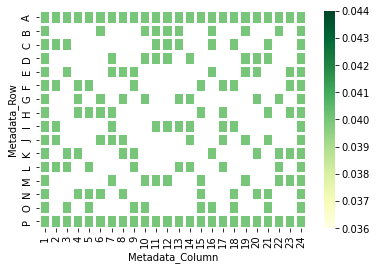

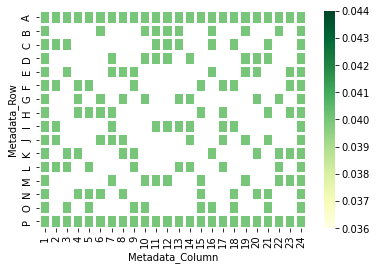

In [99]:
#@title Visualize DMSO normalization

import seaborn as sns 
import pandas as pd 
from IPython import display

DMSOplatelist = dfDMSO['Target Plate'].unique().tolist()

DMSOvisual = dfDMSO
col =       DMSOvisual['Target Well'].astype(str).str[1:3].to_list()
DMSOvisual['Metadata_Column'] = [int(x) for x in col]
DMSOvisual['Metadata_Row']    =       DMSOvisual['Target Well'].astype(str).str[0]


DMSOvisual = DMSOvisual.sort_values("Metadata_Column")

toplot = dfDMSO.pivot(columns="Metadata_Column", index="Metadata_Row", values="Volume [uL]") 

for plate in DMSOplatelist:
  
  hm = sns.heatmap(toplot, 
            #annot=norm_df,
            cmap="YlGn",
            cbar=True,
            lw=2)
  figure = hm.get_figure() 
  display.display(figure)

In [100]:
#@title Merge all target plates

frames      = [df,dfDMSO] 
target      = pd.concat(frames)
target      = target[target["Volume [uL]"] != 0]



In [101]:

#@title Generate DMSO source plate

def createplate(size, direction):

    import string

    if size == 96:
        colr = 13
        rowr = 8
    
    if size == 384:
        colr = 25
        rowr = 16
    

    row = list(string.ascii_uppercase[:rowr])
    col = [(f'{i:02d}') for i in range(1, colr, 1)]
    wells = []
      
    if direction == "vert":
        for c in col:
            for r in row:
                wells.append(str(r+c))
        return(wells)
    
    else:
        for r in row:
            for c in col:
                wells.append(str(r+c))
        return(wells)

def assign_DMSOsource(max_volume, dfvolumes):
    
    wellcapacity = int(max_volume *1e07) # wellcapacity based on idot plate
    well_state = {"well_number": 0, "current_amount": wellcapacity}
    #dfvolumes = dfvolumes.to_list()
    DMSOwells = createplate(size=96,direction="vert")
    
    sourcewelllist = []

    for volume in dfvolumes:
      #print(volume)
        remaining = well_state["current_amount"] - volume
        if remaining < 0:
            well_state["well_number"] += 1
            well_state["current_amount"] = wellcapacity
            wellindex = well_state["well_number"]
            sourcewelllist.append(DMSOwells[wellindex])
        else:
            well_state["current_amount"] -= volume
            wellindex = well_state["well_number"]
            sourcewelllist.append(DMSOwells[wellindex])
            
    sourcewells = [*set(sourcewelllist)]      
    return sourcewelllist

dfvolumes = dfDMSO["Volume [uL]"].to_list()
dfDMSO["Source Well"] = assign_DMSOsource(max_volume, dfvolumes)
dfDMSO[['Liquid Name','Source Plate',]] = 'DMSOsource', 'DMSO'
dmsoSOURCE = dfDMSO[["Liquid Name","Source Plate","Source Well"]].drop_duplicates()
dmsoSOURCE

,Liquid Name,Source Plate,Source Well
0,DMSOsource,DMSO,A01


In [102]:
#@title Source plate preferences

Sourceplate_strat            = 'consecutive' #@param ["flowbot friendly", "consecutive", "dilutions from imported list"]

In [103]:
#@title Generate source plates for treatment and controls

# function to divide conditions over plates for flowbot and opentrons friendly dilutions

def assignsource(df,treatment_type):
    
    import pandas as pd
    import numpy as np
    import math
    import string
    
    if len(df[df['treatment_type']==str(treatment_type)]) == 0: # 
      sourceplate = pd.DataFrame()
      return sourceplate
        
    else:
        seldf                     = df[df['treatment_type']==str(treatment_type)] 
        seldf.stock_conc_mM       = seldf.stock_conc_mM.astype(float)
        seldf["dilutions1in10"]   = np.log10(seldf["highest_stock_mM"].astype(int) / seldf["stock_conc_mM"]).astype(int) + 1
        seldf                     = seldf.groupby(["Liquid Name"])[["cmpdname","stock_conc_mM","dilutions1in10","treatment_type"]].max().reset_index()


        maxdils     = seldf['dilutions1in10'].max() 
        compounds   = np.unique(seldf[['cmpdname']].values).tolist()
        nrcompounds = len(compounds)

        # create source (sub)plates
        nrsubplates        = math.floor(12 / maxdils)                   
        maxcmpdperplate    = nrsubplates * 8                           
        totalsubplates     = math.ceil(nrcompounds / 8)

        plates             = math.ceil(nrcompounds / maxcmpdperplate)  
        plates             = int(plates)

        x = int(math.floor(12/ nrsubplates))
        startcol = [int(f'{i:01d}') for i in range(1, 13, x)] * plates
        startcols = startcol[0:totalsubplates]
        row96 = list(string.ascii_uppercase[:8])
    
        welldict = {}

        # arrange individual compounds on rows and dilutions in columns
        for i, cmp in enumerate(compounds):
            for j, dilution in enumerate(range(0,maxdils)):
            
                comp = i+1
                subplate = math.ceil(comp/8)
                subplateindex = subplate - 1
                subplate = treatment_type + "_" + "source" + str(subplate)

                cmprow = (list(string.ascii_uppercase[:8]) * totalsubplates)[0:len(compounds)]
                cmprow = str(cmprow[i])

                cmpcol = startcols[subplateindex] 
                cmpcol = cmpcol + j 
                cmpcol = str(cmpcol).zfill(2) 
                well = cmprow+cmpcol
                welldict[i,j] = [well,cmp, j+1, subplate]    


        source = pd.DataFrame.from_dict(welldict,orient='index', columns=['Source Well','cmpdname','dilutions1in10', 'Source Plate'])
        sourceplate = pd.merge(seldf, source,  how='left', left_on=['cmpdname','dilutions1in10'], right_on = ['cmpdname','dilutions1in10'])
        
        return(sourceplate)

trtSOURCE  = assignsource(target,"trt")
ctrlSOURCE = assignsource(target,"ctrl")

In [107]:
#@title Visualize control Source plate

if len(ctrlSOURCE.columns) == 0:
  print('no controls source plate was created')
else:
  ctrllist = ctrlSOURCE['Source Plate'].unique().tolist()
  for plate in ctrllist:
      df = ctrlSOURCE[ctrlSOURCE['Source Plate'] == plate ] 
      df['Metadata_Column'] =    df['Source Well'].astype(str).str[1:3]
      df['Metadata_Row']    =    df['Source Well'].astype(str).str[0]
      pivot = df.pivot(columns="Metadata_Column", index="Metadata_Row", values="Liquid Name") 
      print("controls source plate:") 
      print(pivot) 

      pivot.to_csv("ctrl_layout_{}.csv".format(plate), encoding = 'utf-8-sig') 
      files.download("ctrl_layout_{}.csv".format(plate))

controls source plate:
Metadata_Column          01
Metadata_Row               
A                [berb][10]
B                [cyto][10]
C                [etop][10]
D                [fenb][10]
E                [flup][10]
F                [meto][10]
G                [noca][10]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
#@title View treatment plate

# show trt source plates
if len(trtSOURCE.columns) == 0:
  print('no treatment source plate was created')
else:
  trtlist = trtSOURCE['Source Plate'].unique()

  for plate in trtlist:
      df = trtSOURCE[trtSOURCE['Source Plate'] == plate ] 
      df['Metadata_Column'] =    df['Source Well'].astype(str).str[1:3]
      df['Metadata_Row']    =    df['Source Well'].astype(str).str[0]
      pivot = df.pivot(columns="Metadata_Column", index="Metadata_Row", values="Liquid Name") 
      print("treatment source plate:") 
      print(pivot) 

      pivot.to_csv("trt_layout_{}.csv".format(plate), encoding = 'utf-8-sig') 
      files.download("trt_layout_{}.csv".format(plate))

no treatment source plate was created


In [ ]:
#@title Next step is to create and format the idot protocol

frames = [trtSOURCE, ctrlSOURCE, dmsoSOURCE]
source = pd.concat(frames)
source['Source Well']          = source['Source Well'].apply(removeleadingzero)

sourcewell = source[["Liquid Name","Source Well"]]
sourcedictwell = dict(sourcewell.values)

sourceplate = source[["Liquid Name","Source Plate"]]
sourceplatedict = dict(sourceplate.values)

target["Source Well"]  = target["Liquid Name"].map(sourcedictwell)
target["Source Plate"] = target["Liquid Name"].map(sourceplatedict)

sourceplates = source['Source Plate'].unique().tolist()
targetplates = target['Target Plate'].unique().tolist()

sourceplates = sourceplates[::-1]

targetformat = target[["Target Plate","Target Well","Volume [uL]","Liquid Name"]]

collected_df = []
i = 1

for splate in sourceplates:
    for tplate in targetplates:
        df = target.loc[((target["Source Plate"] == splate) & (target["Target Plate"] == tplate ) )]
                      
        df = df[["Source Well","Target Well","Volume [uL]","Liquid Name"]]
        df = df.reindex(columns=[*df.columns.tolist(), "", "","",""], fill_value="")
          
        df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
        df.columns = range(len(df.columns)) 
        
        subheader = [[sourceplate_type, splate, "",max_volume, target_plate_type, tplate, "",waste],
        ["DispenseToWaste="+str(dispense_to_waste),"DispenseToWasteCycles="+str(dispense_to_waste_cycles),"DispenseToWasteVolume="+str(dispense_to_waste_volume),"UseDeionisation="+str(use_deionisation),"OptimizationLevel="+str(optimization_level),"WasteErrorHandlingLevel="+str(waste_error_handling_level),"SaveLiquids="+str(save_liquids),""]]
        subheader = pd.DataFrame(subheader)
        
        protocol = pd.concat([subheader, df],ignore_index=True)
        collected_df.append(protocol)

header = [[protocol_name, software, user_name, date, time,"","",""]]
header = pd.DataFrame(header)

dfs = pd.concat(collected_df)
fullprotocol = pd.concat([header, dfs],ignore_index=True)
fullprotocol


,0,1,2,3,4,5,6,7
0,myexp,1.7.2021.1019,Jonne,01/22/23,20:29:47,,,
1,S.100 Plate,DMSO,,0.00008,MWP 384,plate_1,,Waste Tube
2,DispenseToWaste=True,DispenseToWasteCycles=3,DispenseToWasteVolume=1e-07,UseDeionisation=True,OptimizationLevel=ReorderAndParallel,WasteErrorHandlingLevel=Ask,SaveLiquids=Ask,
3,Source Well,Target Well,Volume [uL],Liquid Name,,,,
4,A1,B14,-0.04,DMSOsource,,,,
...,...,...,...,...,...,...,...,...
195,A1,O23,-0.04,DMSOsource,,,,
196,A1,O4,-0.04,DMSOsource,,,,
197,A1,O6,-0.04,DMSOsource,,,,
198,A1,O7,-0.04,DMSOsource,,,,


In [ ]:
#@title Save the file

fullprotocol.to_csv("3_idotprotocol_{}.csv".format(protocol_name), header=False, index=False,encoding = 'utf-8-sig') 
files.download("3_idotprotocol_{}.csv".format(protocol_name))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>